# The ACME Dataset <a class="tocSkip">

<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Getting-the-data" data-toc-modified-id="Getting-the-data-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Getting the data</a></span></li><li><span><a href="#The-data" data-toc-modified-id="The-data-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>The data</a></span></li><li><span><a href="#The-metadata" data-toc-modified-id="The-metadata-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>The metadata</a></span></li><li><span><a href="#Details-to-note-and-summary-statistics" data-toc-modified-id="Details-to-note-and-summary-statistics-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>Details to note and summary statistics</a></span><ul class="toc-item"><li><span><a href="#Initial-onset-time" data-toc-modified-id="Initial-onset-time-4.1"><span class="toc-item-num">4.1&nbsp;&nbsp;</span>Initial onset time</a></span></li><li><span><a href="#Excerpt-lengths" data-toc-modified-id="Excerpt-lengths-4.2"><span class="toc-item-num">4.2&nbsp;&nbsp;</span>Excerpt lengths</a></span></li></ul></li><li><span><a href="#Compressed-data-for-modelling" data-toc-modified-id="Compressed-data-for-modelling-5"><span class="toc-item-num">5&nbsp;&nbsp;</span>Compressed data for modelling</a></span></li></ul></div>

In [1]:
import logging
from pathlib import Path

import random
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
from IPython.display import display
from tqdm import tqdm

import mdtk
from mdtk.fileio import COLNAMES, csv_to_df
from utils import download_file, unzip_file, plot_from_df

LOGGER = logging.getLogger()

# Getting the data

First, let's obtain the acme dataset and unzip it adjacent to this file.

In [2]:
url = f"https://github.com/JamesOwers/ACME/raw/master/ACMEv1.0.zip"
download_file(url)
unzip_file("ACMEv1.0.zip")

100%|██████████| 42544/42544 [00:10<00:00, 4024.71it/s]


The dataset should now exist at a directory called `ACMEv1.0/acme`, adjacent to this notebook. The contents are as follows:

* `clean` - contains the extracted clean excerpts as csv files
* `altered` - contains the excerpts as csv files altered by the degradations described in `metadata.csv`

`metadata.csv` describes:

* (the id number for) the type of degradation used for the alteration
* the path for the altered and clean files
* which split (train, valid, test) the file should be used in
* in which corpus csv and on what line the file is located

`degradation_ids.csv` is a mapping of degradation name to the id number used in `metadata.csv`

The `{train,valid,test}_cmd_corpus.csv` are command-based (note_on, note_off, shift) versions of the acme data more convenient for our provided pytorch Dataset classes available in the [MIDI Degradation Toolkit](https://github.com/JamesOwers/midi_degradation_toolkit).

Similarly, `{train,valid,test}_pr_corpus.csv` are piano-roll-based versions of the acme data more convenient for our provided pytorch Dataset classes available in the [MIDI Degradation Toolkit](https://github.com/JamesOwers/midi_degradation_toolkit).

In [3]:
acme_root = Path("ACMEv1.0", "acme")

# The data

First let's look at the way the excerpts are stored as csvs. We call each of these a Note DataFrame, or a `note_df`, and they are an ordered list of the notes which have occurred in the excerpt.

Here's a random clean excerpt:

In [4]:
random.seed(1337)
rand_filepath = random.choice(list(Path(acme_root).glob("clean/**/*.csv")))
rand_filepath

PosixPath('ACMEv1.0/acme/clean/PPDDSep2018Monophonic/7cac1a78-4886-4c72-906c-17a2533a789a.csv')

The columns are:
1. onset time of the note in ms
2. the track used to play the note (read: instrument)
3. the MIDI pitch number (60 is C4)
4. the duration of the note in ms

In [5]:
df = pd.read_csv(rand_filepath, names=["onset", "track", "pitch", "dur"])
with pd.option_context("display.max_rows", 10):
    display(df)

,onset,track,pitch,dur
0,121,0,86,83
1,246,0,74,83
2,371,0,62,83
3,496,0,74,83
4,621,0,84,83
...,...,...,...,...
32,4496,0,77,83
33,4621,0,77,83
34,4746,0,76,83
35,4871,0,76,83


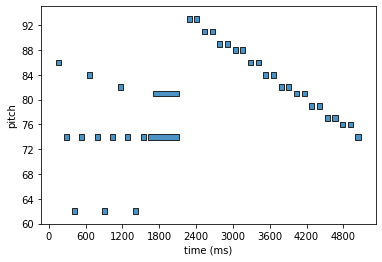

In [6]:
plot_from_df(df)

Each excerpt has a matching degraded version (excluding those which are not degraded!)

In [7]:
alt_path = Path(*rand_filepath.parts[:-3], "altered", *rand_filepath.parts[-2:])
alt_path

PosixPath('ACMEv1.0/acme/altered/PPDDSep2018Monophonic/7cac1a78-4886-4c72-906c-17a2533a789a.csv')

,onset,track,pitch,dur
0,121,0,86,83
1,246,0,74,83
2,371,0,62,83
3,496,0,74,83
4,621,0,84,83
...,...,...,...,...
32,4496,0,77,83
33,4621,0,77,83
34,4746,0,76,83
35,4871,0,76,83


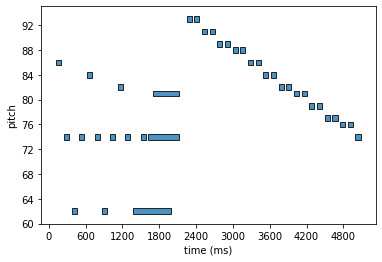

In [8]:
alt_df = pd.read_csv(alt_path, names=["onset", "track", "pitch", "dur"])
with pd.option_context("display.max_rows", 10):
    display(alt_df)
plot_from_df(alt_df)

Can you see where it has been altered?! There is only one degradation applied to each altered example.

# The metadata

All the information about how the excerpts have been degraded is contained within `metadata.csv`. The names of the degradations are in `degredation_ids.csv`. Each row of `metadata.csv` gives the following information for each excerpt:
* the clean and altered path (relative to the root directory),
* a flag showing if the excerpt was degraded, and which degradation was used,
* and the location of the data within the compressed corpus files (more on these later).

These can be used by a data parser to get the required input data, labels, or target data required.


In [9]:
meta_df = pd.read_csv(Path(acme_root, "metadata.csv"))
display(meta_df.dtypes)
meta_df.head()

altered_csv_path      object
degraded               int64
degradation_id         int64
clean_csv_path        object
split                 object
cmd_corpus_path       object
cmd_corpus_line_nr     int64
pr_corpus_path        object
pr_corpus_line_nr      int64
dtype: object

,altered_csv_path,degraded,degradation_id,clean_csv_path,split,cmd_corpus_path,cmd_corpus_line_nr,pr_corpus_path,pr_corpus_line_nr
0,altered/PPDDSep2018Polyphonic/10e6a18b-8e05-49...,1,2,clean/PPDDSep2018Polyphonic/10e6a18b-8e05-497a...,train,train_cmd_corpus.csv,0,train_pr_corpus.csv,0
1,altered/PPDDSep2018Monophonic/6932d4e8-77cc-4d...,1,7,clean/PPDDSep2018Monophonic/6932d4e8-77cc-4d97...,valid,valid_cmd_corpus.csv,0,valid_pr_corpus.csv,0
2,altered/PPDDSep2018Monophonic/236ec542-6b2a-42...,1,5,clean/PPDDSep2018Monophonic/236ec542-6b2a-429e...,train,train_cmd_corpus.csv,1,train_pr_corpus.csv,1
3,altered/PPDDSep2018Polyphonic/3c22fabd-9fa8-4b...,1,1,clean/PPDDSep2018Polyphonic/3c22fabd-9fa8-4b64...,train,train_cmd_corpus.csv,2,train_pr_corpus.csv,2
4,altered/PPDDSep2018Monophonic/95e2154b-f824-44...,1,3,clean/PPDDSep2018Monophonic/95e2154b-f824-44c9...,test,test_cmd_corpus.csv,0,test_pr_corpus.csv,0


In [10]:
deg_df = pd.read_csv(Path(acme_root, "degradation_ids.csv"), index_col="id")
deg_df

,degradation_name
id,
0,none
1,pitch_shift
2,time_shift
3,onset_shift
4,offset_shift
5,remove_note
6,add_note
7,split_note
8,join_notes


For example, taking a few random rows from the metadata:

In [11]:
random.seed(1337)
idx_sample = random.sample(range(len(meta_df)), 4)
idx_sample

[20242, 17474, 11988, 18709]

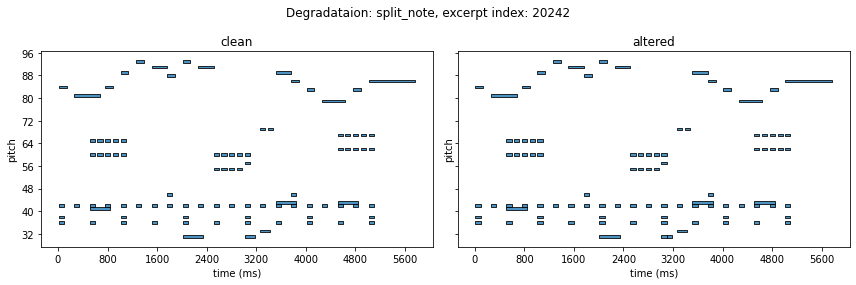

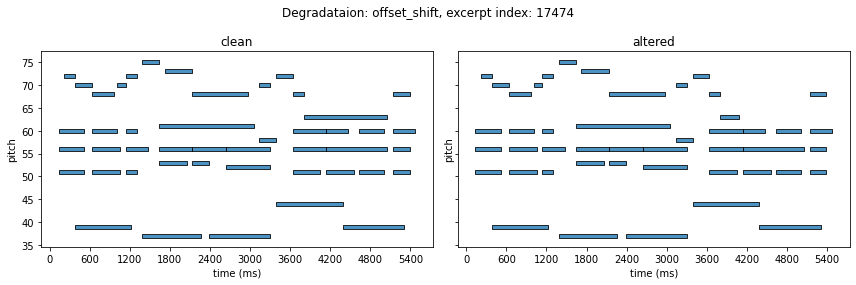

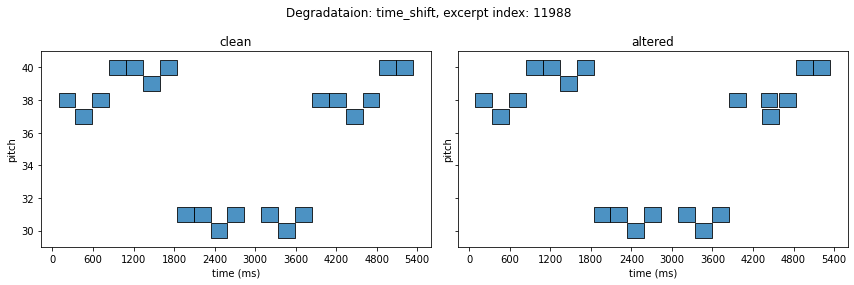

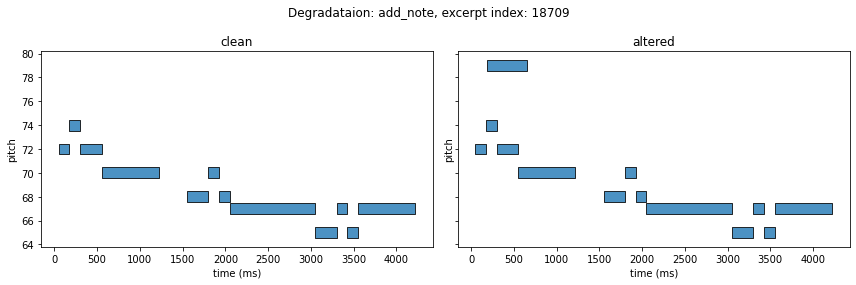

In [12]:
def inspect_by_index(idx, meta_df):
    excerpt_meta = meta_df.loc[idx]
    deg_name = deg_df.loc[excerpt_meta.degradation_id, "degradation_name"]
    clean_path = acme_root / Path(excerpt_meta["clean_csv_path"])
    alt_path = acme_root / Path(excerpt_meta["altered_csv_path"])
    clean_df = csv_to_df(clean_path)
    alt_df = csv_to_df(alt_path)
    fig, (ax0, ax1) = plt.subplots(1, 2, figsize=(12, 4), sharex=True, sharey=True)
    plot_from_df(clean_df, ax=ax0)
    ax0.set_title("clean")
    plot_from_df(alt_df, ax=ax1)
    ax1.set_title("altered")
    title = f"Degradataion: {deg_name}, excerpt index: {idx}"
    plt.suptitle(title)
    plt.tight_layout()


for idx in idx_sample:
    inspect_by_index(idx, meta_df)

# Details to note and summary statistics

Most details are included in the paper in section 3. But we outline details here too.

* all excerpts are approximately 5 seconds long

* the onset time for the excerpt doesn't match the file it was taken from,
* but the onset times of the clean and altered examples are aligned
* a random amount of silence was added to the start of each excerpt to allow for the first note to be degraded
* an equal proportion of all the degradations

In [13]:
all_clean_df = [
    csv_to_df(acme_root / Path(path)) for path in tqdm(meta_df.clean_csv_path)
]
# N.B. this includes clean dfs if deg is None
all_alt_df = [
    csv_to_df(acme_root / Path(path)) for path in tqdm(meta_df.altered_csv_path)
]

100%|██████████| 22514/22514 [01:03<00:00, 354.94it/s]


## Initial onset time

The inital onsets are uniformly distributed between 0 and 200 ms

In [14]:
clean_first_onsets = [df.at[0, "onset"] for df in tqdm(all_clean_df)]
alt_first_onsets = [df.at[0, "onset"] for df in tqdm(all_alt_df)]

100%|██████████| 22514/22514 [00:01<00:00, 12343.69it/s]


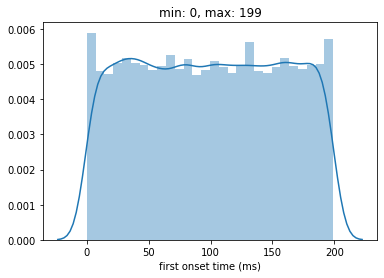

In [15]:
sns.distplot(clean_first_onsets)
plt.title(f"min: {min(clean_first_onsets)}, max: {max(clean_first_onsets)}")
plt.xlabel("first onset time (ms)")
plt.show()

For each excerpt, if we observe the difference between the first onsets, we see they are normally the same, but that some degradations alter the first note in some way, causing a difference.

In [16]:
diff_first_onsets = [
    alt - clean for alt, clean in zip(alt_first_onsets, clean_first_onsets)
]

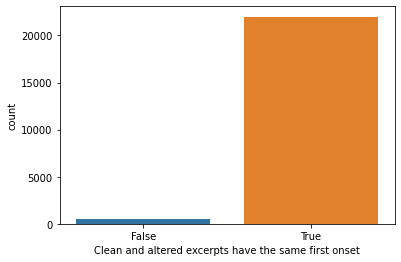

In [17]:
sns.countplot([diff == 0 for diff in diff_first_onsets])
plt.xlabel("Clean and altered excerpts have the same first onset")
plt.show()

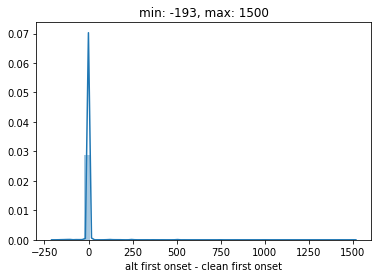

In [18]:
sns.distplot(diff_first_onsets)
plt.title(f"min: {min(diff_first_onsets)}, max: {max(diff_first_onsets)}")
plt.xlabel("alt first onset - clean first onset")
plt.show()

There are 527 examples where the onset time of the clean and altered excerpt are not the same


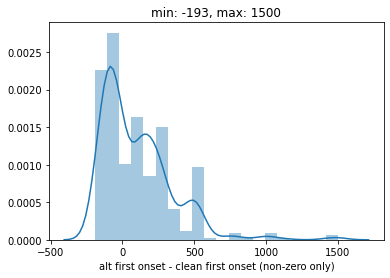

In [19]:
nonzero_diffs = [diff for diff in diff_first_onsets if diff != 0]
print(
    f"There are {len(nonzero_diffs)} examples where the onset time of the "
    "clean and altered excerpt are not the same"
)
sns.distplot(nonzero_diffs)
plt.title(f"min: {min(nonzero_diffs)}, max: {max(nonzero_diffs)}")
plt.xlabel("alt first onset - clean first onset (non-zero only)")
plt.show()

Let's have a look at the most extreme examples where then onset of the clean and altered versions differ the most.

In [20]:
def argmax(sequence):
    _, idx = max((val, idx) for idx, val in enumerate(sequence))
    return idx


def argmin(sequence):
    _, idx = min((val, idx) for idx, val in enumerate(sequence))
    return idx

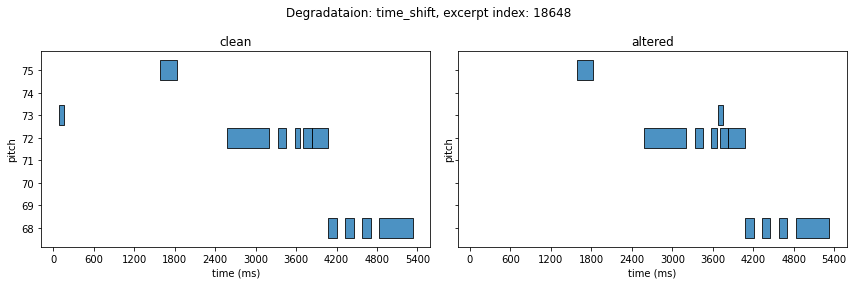

In [21]:
inspect_by_index(argmax(diff_first_onsets), meta_df)

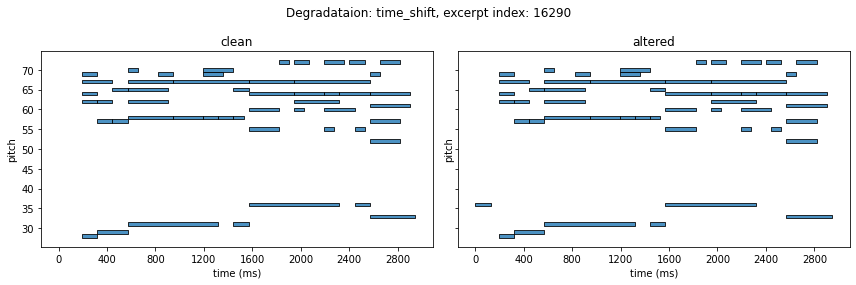

In [22]:
inspect_by_index(argmin(diff_first_onsets), meta_df)

In [23]:
nonzero_diff_idx = [idx for idx, diff in enumerate(diff_first_onsets) if diff != 0]

In [24]:
meta_df["degradation_str"] = meta_df.degradation_id.apply(lambda x: deg_df.loc[x])

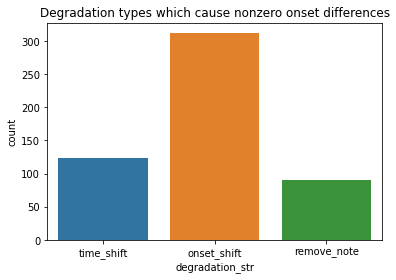

In [25]:
sns.countplot(meta_df.loc[nonzero_diff_idx, "degradation_str"])
plt.title("Degradation types which cause nonzero onset differences")
plt.show()

## Excerpt lengths

The code for selecting excerpts from a whole piece is `mdtk.df_utils.get_random_excerpt`.

By default, and as used for ACMEv1.0, we select an  ~5 second excerpt from each piece by choosing a random note and all notes beginning in the subsequent 5 seconds, but require that at least 10 notes be present. The excerpt ends when the last held note is released.

As such, if there are notes held for a long time, or if there are relatively few notes within the selected 5 second window, the excerpt may be longer or shorter than 5 seconds respectively.

In [26]:
?mdtk.df_utils.get_random_excerpt

Signature:
mdtk.df_utils.get_random_excerpt(
    note_df,
    min_notes=10,
    excerpt_length=5000,
    first_onset_range=(0, 200),
    iterations=10,
)
Docstring:
Take a random excerpt from the given note_df, using np.random. The excerpt
is created as follows:

1. Pick a note at random from the input df, excluding the last `min_notes`
   notes.
2. Take all notes which onset within `excerpt_length` ms of that note.
3. If the excerpt does not contain at least `min_notes` notes, repeat steps
   1 and 2 until you have drawn `iterations` invalid excerpts. In that
   case, return None.
4. If you have a valid excerpt, shift its notes so that the first note's
   onset is at time 0, then add a random number within `first_onset_range`
   to each onset.
5. Return the resulting excerpt.

Parameters
----------
note_df : pd.DataFrame
    The input note_df, from which we want a random excerpt.

min_notes : int
    The minimum number of notes that must be contained in a valid excerpt.

excerpt_lengt

In [27]:
clean_last_offsets = [(df["onset"] + df["dur"]).max() for df in tqdm(all_clean_df)]
alt_last_offsets = [(df["onset"] + df["dur"]).max() for df in tqdm(all_alt_df)]

100%|██████████| 22514/22514 [00:04<00:00, 5444.11it/s]


In [28]:
clean_dur = [
    last_off - first_on for first_on, last_off in 
    zip(clean_first_onsets, clean_last_offsets)
]

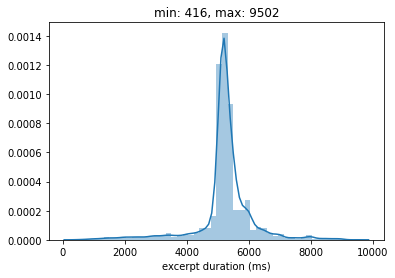

In [29]:
sns.distplot(clean_dur)
plt.title(f"min: {min(clean_dur)}, max: {max(clean_dur)}")
plt.xlabel("excerpt duration (ms)")
plt.show()

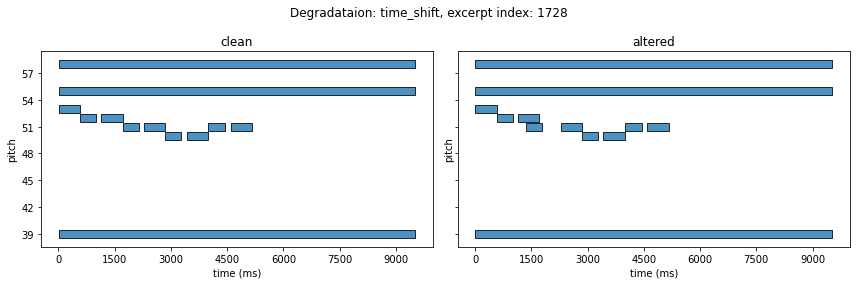

In [30]:
inspect_by_index(argmax(clean_dur), meta_df)

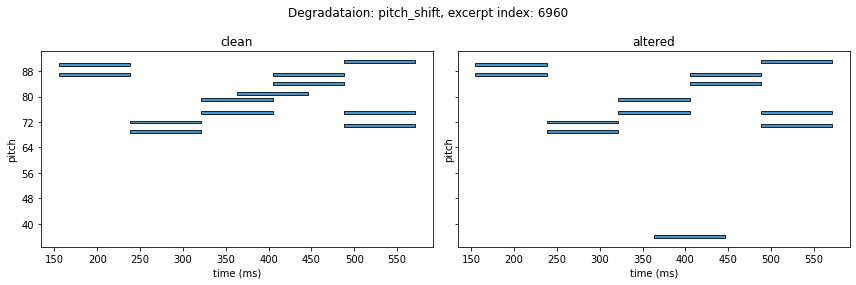

In [31]:
inspect_by_index(argmin(clean_dur), meta_df)

# Compressed data for modelling

We have also provided data in two other formats - piano roll and command format. We detail these in a subsequent notebook: [04_data_parsers_and_degrader.ipynb](./04_data_parsers_and_degrader.ipynb).